Debug notes:
1.loaded notebook from https://github.ibm.com/physical-analytics/pairs-applications/tree/master/SampleApplications/ClimateChange/CharacterizingClimateChange
2.added pip install for ibmpairs and opencv-python, maybe they should be added to the image ? 
3.created file  'ibmpairspass.txt' and created simple instructions for adding credentials
4.all seems to work until cell[10] - going to ask Johannes for help in debug

This is a demo script to illustrate the power of PAIRS. As we all know, there is a lot of talk on climate change, i.e. whether our climate will change or has changed. While forecasting climate change is an ongoing and complex research topic, we can use PAIRS to find out how much the climate has changed in the last 4 decades? 

So let's start with the Continental United States. In PAIRS we have the PRISM data sets http://prism.oregonstate.edu/. For example, we have the daily max temperature (id=92) at 4km spatial resolution starting from 1981 until today.

The area of the continental US is ~ 8M square km meaning that we have ~2M data points every day for 39 years. To get started let's submit a query to PAIRS to obtain this data for a selected date.

In [1]:
pip install ibmpairs

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
from ibmpairs import paw
from datetime import datetime, timedelta
import re, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

#import h5py

###############################################################################################
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
# Note you need to edit the file 'ibmpairspass.txt' and add your user id and the PAIRS password  
# we supply. that file will work with all PAIRS examples 
# you also need to put your IBMid userid here 
PAIRS_USER        = 'johncohn@us.ibm.com'  
#PAIRS_USER        = '<userid>' 
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
###############################################################################################

PAIRS_SERVER      = 'https://pairs.res.ibm.com'
PAIRS_CREDENTIALS = (PAIRS_USER, paw.get_pairs_api_password(PAIRS_SERVER, PAIRS_USER, passFile='ibmpairspass.txt'))

iso8601 = '%Y-%m-%dT%H:%M:%SZ'

In [4]:
aoi=24             #AOI=24 is the continental US
queryJson = {
    "layers" : [
        {"type" : "raster", "id" : "92"}
    ],
    "spatial" : {"type" : "poly",  "aoi" :aoi},
    "temporal" : {"intervals" : [
        {"snapshot" : "2018-05-31T00:00:00Z"}
    ]}
}
query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS)
query.submit()
query.poll_till_finished()
query.download()
query.create_layers()

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.


Such a query takes usually a few seconds to run (~40s). 
Of course, we are interested in finding out whether or not the temperatures have changed in the last 38 years, which means  - naively - one would have to run 39 * 365 = 14235 queries, which would take 158 hours or more than 6 days. 

The good news is that with PAIRS we can submit such a query without downloading the data with user-defined functions, which we can submit with the query. 

For this we can write a function (generateQueryJson), which generates the user defined functions in form a json which
1. calculates the average values (e.g., maximum temperature) for earch year (for PRISM from 1981 to 2019) for each location
2. performs a linear regression to obtain the annual change (e.g. annual temperature change in oC/year) for each location, and
3. estimates the standard error of the annual change (e.g. error of the annual temperature change in oC/year) for each location.

We also write a simple procedure to view the results (showPAIRSdata), which can also smooth the data for better visualization if needed.

In [5]:
def generateQueryJson(layer_id,agg,startDate,duration,N,aoi):
#calculate the average annual value
    queryJson = {
        'layers' : [
            {
                'alias' : 'Y{0}'.format(str(years+startDate.year).zfill(2)),
                'aggregation' : agg,
                'type' : 'raster', 
                'id' : layer_id,
                'temporal' : {'intervals' : [{
                    'start' : (startDate.replace(startDate.year + years)).strftime(iso8601),
                    'end' : (startDate.replace(startDate.year + years) + timedelta(days = duration)).strftime(iso8601)
                }]},
                'output' : False
            }
            for years in range(0,N) ],
        'spatial' : {'type' : 'poly',  'aoi' : aoi},
        'temporal' : {'intervals' : [{'snapshot' : startDate.strftime(iso8601)}]},
    }

#calculate the mean of x     
    queryJson['layers'].extend([{
        'alias' : 'xm',
        'expression' : '('+'+'.join([
            '{0}'.format(str(years+startDate.year).zfill(2))
            for years in range(0,N)
        ] 
        )}
    ])
    queryJson['layers'][N]['expression']=queryJson['layers'][N]['expression']+')'+'/'+str(N)
    queryJson['layers'][N].update({'output' : False})
    
#calculate the mean of y     
    queryJson['layers'].extend([{
        'alias' : 'ym',
        'expression' : '('+'+'.join([
            '$Y{0}'.format(str(years+startDate.year).zfill(2))
            for years in range(0,N)
        ] 
        )}
    ])
    queryJson['layers'][N+1]['expression']=queryJson['layers'][N+1]['expression']+')'+'/'+str(N)
    queryJson['layers'][N+1].update({'output' : False})
    
#calculate Sxx     
    queryJson['layers'].extend([{
        'alias' : 'Sxx',
        'expression' : ' + '.join([
            '({0}-$xm)*({0}-$xm)'.format(str(years+startDate.year).zfill(2))
            for years in range(0,N)
        ] 
        )}
    ])    
    queryJson['layers'][N+2].update({'output' : False})

#calculate Syy     
    queryJson['layers'].extend([{
        'alias' : 'Syy',
        'expression' : ' + '.join([
            '($Y{0}-$ym)*($Y{0}-$ym)'.format(str(years+startDate.year).zfill(2))
            for years in range(0,N)
        ] 
        )}
    ])
    queryJson['layers'][N+3].update({'output' : False})
        
#calculate Sxy     
    queryJson['layers'].extend([{
        'alias' : 'Sxy',
        'expression' : ' + '.join([
            '({0}-$xm)*($Y{0}-$ym)'.format(str(years+startDate.year).zfill(2))
            for years in range(0,N)
        ] 
        )}
    ])
    queryJson['layers'][N+4].update({'output' : False})
    
#calculate slope
    queryJson['layers'].extend([{
        'alias' : 'slope',
        'expression' : '$Sxy/$Sxx'
        }]
   )  

#calculate standard error 
    queryJson['layers'].extend([{
        'alias' : 'error',
        'expression' : 'math:sqrt(($Syy-($Sxy*$Sxy/$Sxx))/($Sxx*'+str(N-2)+'))'
        }]
   )  
    return queryJson

def showPAIRSdata(out_id,figuretitle,filename,n,vmin,vmax):
    query_metadata = pd.DataFrame(query.metadata).transpose()
    out_id=out_id
    extent = [
        query.metadata[out_id]['details']['boundingBox'][k]
        for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
    ]
    out=query.data[out_id]
    kernel = np.ones((n,n),np.float32)/n/n
    out_filtered = cv2.filter2D(out,-1,kernel)
    fig=plt.figure(figsize=(16,8))
    plt.imshow(out_filtered, extent = extent, cmap = 'plasma',vmin=vmin,vmax=vmax)
    plt.colorbar()
    fig.suptitle(figuretitle)
    fig.savefig(filename)
    return

 Okay now let's look at this query, which generateQueryJson generates. It is quite a lot of (simple) math...:(
 We also specifiy a start date, the time period (days) and the total numbers of years (N).

In [6]:
import datetime
startDate = datetime.date(1981,1,1)
days=365
N=39
aggregation='Mean'
dset=92
# id 92 is Daily max temperature from PRISM - see PAIRS data catalogue
queryJson = generateQueryJson(dset,aggregation,startDate,days,N,aoi)
queryJson

{'layers': [{'alias': 'Y1981',
   'aggregation': 'Mean',
   'type': 'raster',
   'id': 92,
   'temporal': {'intervals': [{'start': '1981-01-01T00:00:00Z',
      'end': '1982-01-01T00:00:00Z'}]},
   'output': False},
  {'alias': 'Y1982',
   'aggregation': 'Mean',
   'type': 'raster',
   'id': 92,
   'temporal': {'intervals': [{'start': '1982-01-01T00:00:00Z',
      'end': '1983-01-01T00:00:00Z'}]},
   'output': False},
  {'alias': 'Y1983',
   'aggregation': 'Mean',
   'type': 'raster',
   'id': 92,
   'temporal': {'intervals': [{'start': '1983-01-01T00:00:00Z',
      'end': '1984-01-01T00:00:00Z'}]},
   'output': False},
  {'alias': 'Y1984',
   'aggregation': 'Mean',
   'type': 'raster',
   'id': 92,
   'temporal': {'intervals': [{'start': '1984-01-01T00:00:00Z',
      'end': '1984-12-31T00:00:00Z'}]},
   'output': False},
  {'alias': 'Y1985',
   'aggregation': 'Mean',
   'type': 'raster',
   'id': 92,
   'temporal': {'intervals': [{'start': '1985-01-01T00:00:00Z',
      'end': '1986-01

Now, let's submit this query and see what happens...

In [7]:
query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS)
query.submit()
query.poll_till_finished()
query.download()
query.create_layers()

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.
GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.


This query takes typically around ~ 7 min, which is more than 1000x faster than downloading each data set. In fact it is even better because we have already computed the answer to our question, which is ready to be viewed.

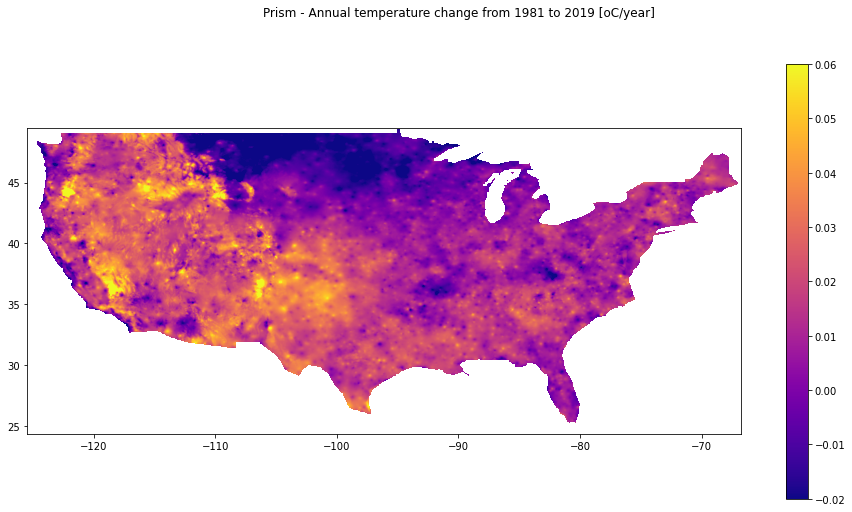

In [8]:
showPAIRSdata('Expression-slope[slope]-Exp','Prism - Annual temperature change from 1981 to 2019 [oC/year]','Prism-temp.png',1,-0.02,0.06)

This is very interesting. Most places in the US have warmed over the last 39 years with a rate of 0.02 to 0.04 C/year, which means between 0.8 and 1.6C (or 1.4 to 2.8F). The Western and Southwestern part of the US has warmed faster than the eastern part. Parts of the Midwest have seen the least amount of warming or even some cooling. Now let's have a look at the error of this trend. 

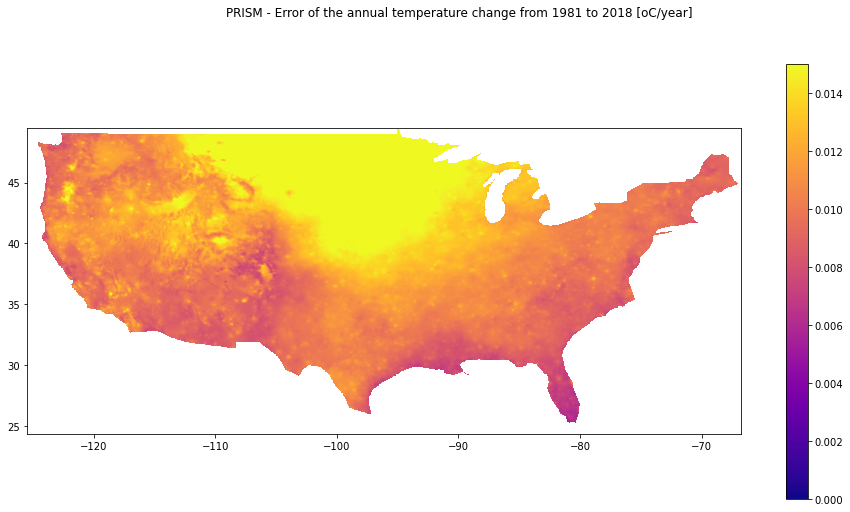

In [9]:
showPAIRSdata('Expression-error[error]-Exp','PRISM - Error of the annual temperature change from 1981 to 2018 [oC/year]','Prism-error.png',n=2,vmin=0.00,vmax=0.015)